# basic idea
- 기존 ML 기반 클러스터링은 잘 작동하지 않았음
- 텍스트가 주제 분류될 때 복잡한 과정을 거치기 때문 ex) KT wiz와 삼성 라이온즈의 맞대결 승자는? &rarr; 스포츠; 하지만 KT와 삼성이라는 단어 때문에 경제로 분류될 가능성 있음.
- 복잡한 로직의 처리를 LLM으로 하면 어떨까? &rarr; LLM 사용 시 출력 컨트롤이 관건
    1. 출력이 영어로 되는 경우 - 프롬프트에서 한국어 명시
    2. 출력이 균일하게 되지 않는 경우 - seed와 temperature 관리
    3. 출력에 노이즈가 생기는 경우 - 노이즈 양에 따라 허용 or 무시

In [1]:
import re
import pandas as pd
import os

from filter import SpecialCharFilter

from langchain_ollama import ChatOllama
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
from tqdm import tqdm

In [2]:
df: pd.DataFrame = pd.read_csv('data/train.csv')

special_char_filter = SpecialCharFilter()

noise_df = special_char_filter.filter_noise(df)
clean_df = df[~df.index.isin(noise_df.index)]
print(len(noise_df), len(clean_df))
noise_df.head()

1595 1205


,ID,text,target,special_char_count,special_char_ratio
0,ynat-v1_train_00000,정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보,4,6,0.187500
1,ynat-v1_train_00001,K찰.국DLwo 로L3한N% 회장 2 T0&}송=,3,7,0.259259
2,ynat-v1_train_00002,"m 김정) 자주통일 새,?r열1나가야1보",2,5,0.227273
4,ynat-v1_train_00004,pI美대선I앞두고 R2fr단 발] $비해 감시 강화,6,5,0.178571
6,ynat-v1_train_00006,프로야구~롯TKIAs광주 경기 y천취소,1,3,0.142857


In [3]:
prompt = ChatPromptTemplate.from_messages(
    messages=[
        (
            "system",
            """
            You are a helpful assistant that categories news article titles to propre sections. 
            only say in a short korean word.
            """,
        ),
        (
            "human",
            "{input}",
        )
    ]
)

llm = ChatOllama(
    model="gemma2:27b",
    seed=42,
    temperature=0
)

chain = prompt | llm

In [4]:
cluster_path = "data/clustered.csv"

if not os.path.exists(cluster_path):
    for idx, row in clean_df.iterrows():
        input_text = row['text']
        ai_msg = chain.invoke({"input": input_text})
        predicted_label = ai_msg.content.strip()  # 결과 문자열에서 공백 제거
        clean_df.loc[idx, 'predict_label'] = re.sub(r'[^가-힣a-zA-Z\s]', '', predicted_label)
        print(f"Index: {idx}, Input: {input_text}, Predicted Label: {predicted_label}")
else:
    clean_df = pd.read_csv(cluster_path)

위 실행 결과를 보면, 다양한 label로 분류되는 걸 알 수 있다. 따라서 label 텍스트 자체를 임베딩해 클러스터링을 시도한다.

# 실험 1: BERT embedding + K-Means

In [ ]:
clean_df.to_csv('data/clustered.csv')

In [ ]:
label_counts = clean_df['predict_label'].value_counts()
label_counts.head(10)

klue/bert-base 모델을 활용해 토큰화 및 임베딩 후 k-means 알고리즘으로 클러스터링을 한다.

In [ ]:
# model_name = "klue/bert-base"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

In [ ]:
# def get_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=32, padding="max_length")
#     outputs = model(**inputs)
#     # [CLS] 토큰의 출력만 사용하여 임베딩 생성
#     embedding = outputs.last_hidden_state[:, 0, :].squeeze().detach().numpy()
#     return embedding

In [ ]:
# embeddings = clean_df['predict_label'].astype(str).apply(get_embedding).tolist()
# embeddings = torch.tensor(embeddings)  # 리스트를 텐서로 변환

# # KMeans 클러스터링 (7개의 클러스터로 설정)
# kmeans = KMeans(n_clusters=7, random_state=42)
# clean_df['label_cluster'] = kmeans.fit_predict(embeddings)

# # 클러스터링 결과 확인
# print(clean_df[['predict_label', 'label_cluster']].head())

In [ ]:
# cluster_counts = clean_df['label_cluster'].value_counts()
# print("\nCluster distribution:")
# print(cluster_counts)

In [ ]:
# cross_tab = pd.crosstab(clean_df['label_cluster'], clean_df['target'])
# cross_tab

클러스터링 실험 결과 사전에 분석한 라벨 분포와 다르다. 사전 분석 시 라벨이 골고루 분포되어 있었다.

# 실험 2: LLM 라벨 예측 결과 분류 - 대화 정보 기억

LLM의 출력 결과를 7가지로 추리기 위해서 어떤 기능을 사용해야 할까?
LLM agent에서 버퍼 메모리 기능 사용해보기

In [ ]:
store = {}

def get_session_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
    return store[session_id]

chain = RunnableWithMessageHistory(llm, get_session_history)

In [ ]:
def extract_categories(titles, session_id):
    prompt = (
        "다음은 뉴스 기사 제목들의 목록입니다:\n\n"
        + "\n".join(titles)
        + "\n\n이 제목들을 7개의 대표적인 카테고리로 분류하여, 각 카테고리의 이름만 한 단어로 출력하세요."
    )
    response = chain.invoke(
        prompt,
        config={"configurable": {"session_id": session_id}},
    )
    return response.content.strip()

def classify_title(title, categories, session_id):
    prompt = (
        f"다음은 뉴스 기사 제목입니다:\n\n"
        f"제목: {title}\n\n"
        f"반드시 아래의 카테고리 중 하나로 분류하고, 해당 카테고리의 이름만 한 단어로 출력하세요:\n{', '.join(categories)}"
    )
    response = chain.invoke(
        prompt,
        config={"configurable": {"session_id": session_id}},
    )
    return response.content.strip()

In [ ]:
# 예시 기사 제목 리스트
titles = clean_df['text'].to_list()

# 세션 ID 설정
session_id = "1"

if not os.path.exists('data/clustered_7_labels.csv'):
    # 1. 카테고리 추출
    categories = extract_categories(titles, session_id)
    print("추출된 카테고리:\n", categories)

    # 2. 각 제목에 대한 분류
    classified_categories = []
    for title in tqdm(titles):
        category = classify_title(title, categories, session_id)
        classified_categories.append(category)
        print(f"제목: {title}\n분류된 카테고리: {category}\n")
        
    clean_df['label_cluster'] = classified_categories
    clean_df.to_csv('data/clustered_7_labels.csv')
else:
    clean_df = pd.read_csv('data/clustered_7_labels.csv')      

백그라운드 실행 명령어
```bash
nohup ollama serve &
nohup jupyter nbconvert --to notebook --execute LLM_based_clustering.ipynb --output LLM_based_clustering_output.ipynb &
```

In [ ]:
label_count = clean_df['label_cluster'].value_counts()
label_count

In [ ]:
most_labels = label_count.head(7).index.to_list()
extra = clean_df[~clean_df['label_cluster'].isin(most_labels)]
extra

In [ ]:
extra['label_cluster'] = extra['label_cluster'].apply(lambda x: classify_title(x, most_labels, session_id))
extra

In [ ]:
label_count = extra['label_cluster'].value_counts()
label_count

In [ ]:
clean_df.update(extra[['label_cluster']])

columns_to_drop = ['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1' ,
                   'special_char_count', 'special_char_ratio', 'predict_label']
clean_df.drop(columns=columns_to_drop, inplace=True)

clean_df

In [ ]:
label_count = clean_df['label_cluster'].value_counts()
label_count

In [ ]:
clean_df.to_csv('data/clustered_7_labels.csv')

# 결과 분석

In [5]:
clustered_df = pd.read_csv('data/clustered_7_labels.csv')

# ASCII 데이터 예측을 통해 정수 인코딩이 의미하는 실제 카테고리 내용 파악 완료
clustered_df['target'] = clustered_df['target'].apply(lambda x: {0: '생활문화', 1: '스포츠', 2: '정치', 3: '사회', 4: 'IT과학', 5: '경제', 6: '세계'}.get(x, x))

# 위 실험 결과로 매핑 완료
clustered_df['label_cluster'] = clustered_df['label_cluster'].apply(
    lambda x: {
        "경제": "경제", 
        "스포츠": "스포츠", 
        "정치": "정치", 
        "국제": "세계", 
        "문화": "생활문화", 
        "사회": "사회", 
        "과학": "IT과학",
    }.get(x, x)
)

clustered_df = clustered_df[['ID', 'text', 'target', 'label_cluster']]
clustered_df

,ID,text,target,label_cluster
0,ynat-v1_train_00003,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,경제,경제
1,ynat-v1_train_00005,美성인 6명 중 1명꼴 배우자 연인 빚 떠안은 적 있다,생활문화,사회
2,ynat-v1_train_00007,아가메즈 33득점 우리카드 KB손해보험 완파 3위 굳,IT과학,스포츠
3,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요 경주 지진현장 방문종합,세계,정치
4,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔 알뜰폰 기대감,IT과학,경제
...,...,...,...,...
1200,ynat-v1_train_02794,문 대통령 김기식 금감원장 사표 수리키로종합,정치,정치
1201,ynat-v1_train_02795,트럼프 폭스뉴스 앵커들 충성도 점수매겨 10점만점에 12점도,세계,세계
1202,ynat-v1_train_02796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,정치,경제
1203,ynat-v1_train_02798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해 승부는 냉정,스포츠,스포츠


In [6]:
len(clustered_df[clustered_df['target'] == clustered_df['label_cluster']])

214

In [7]:
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

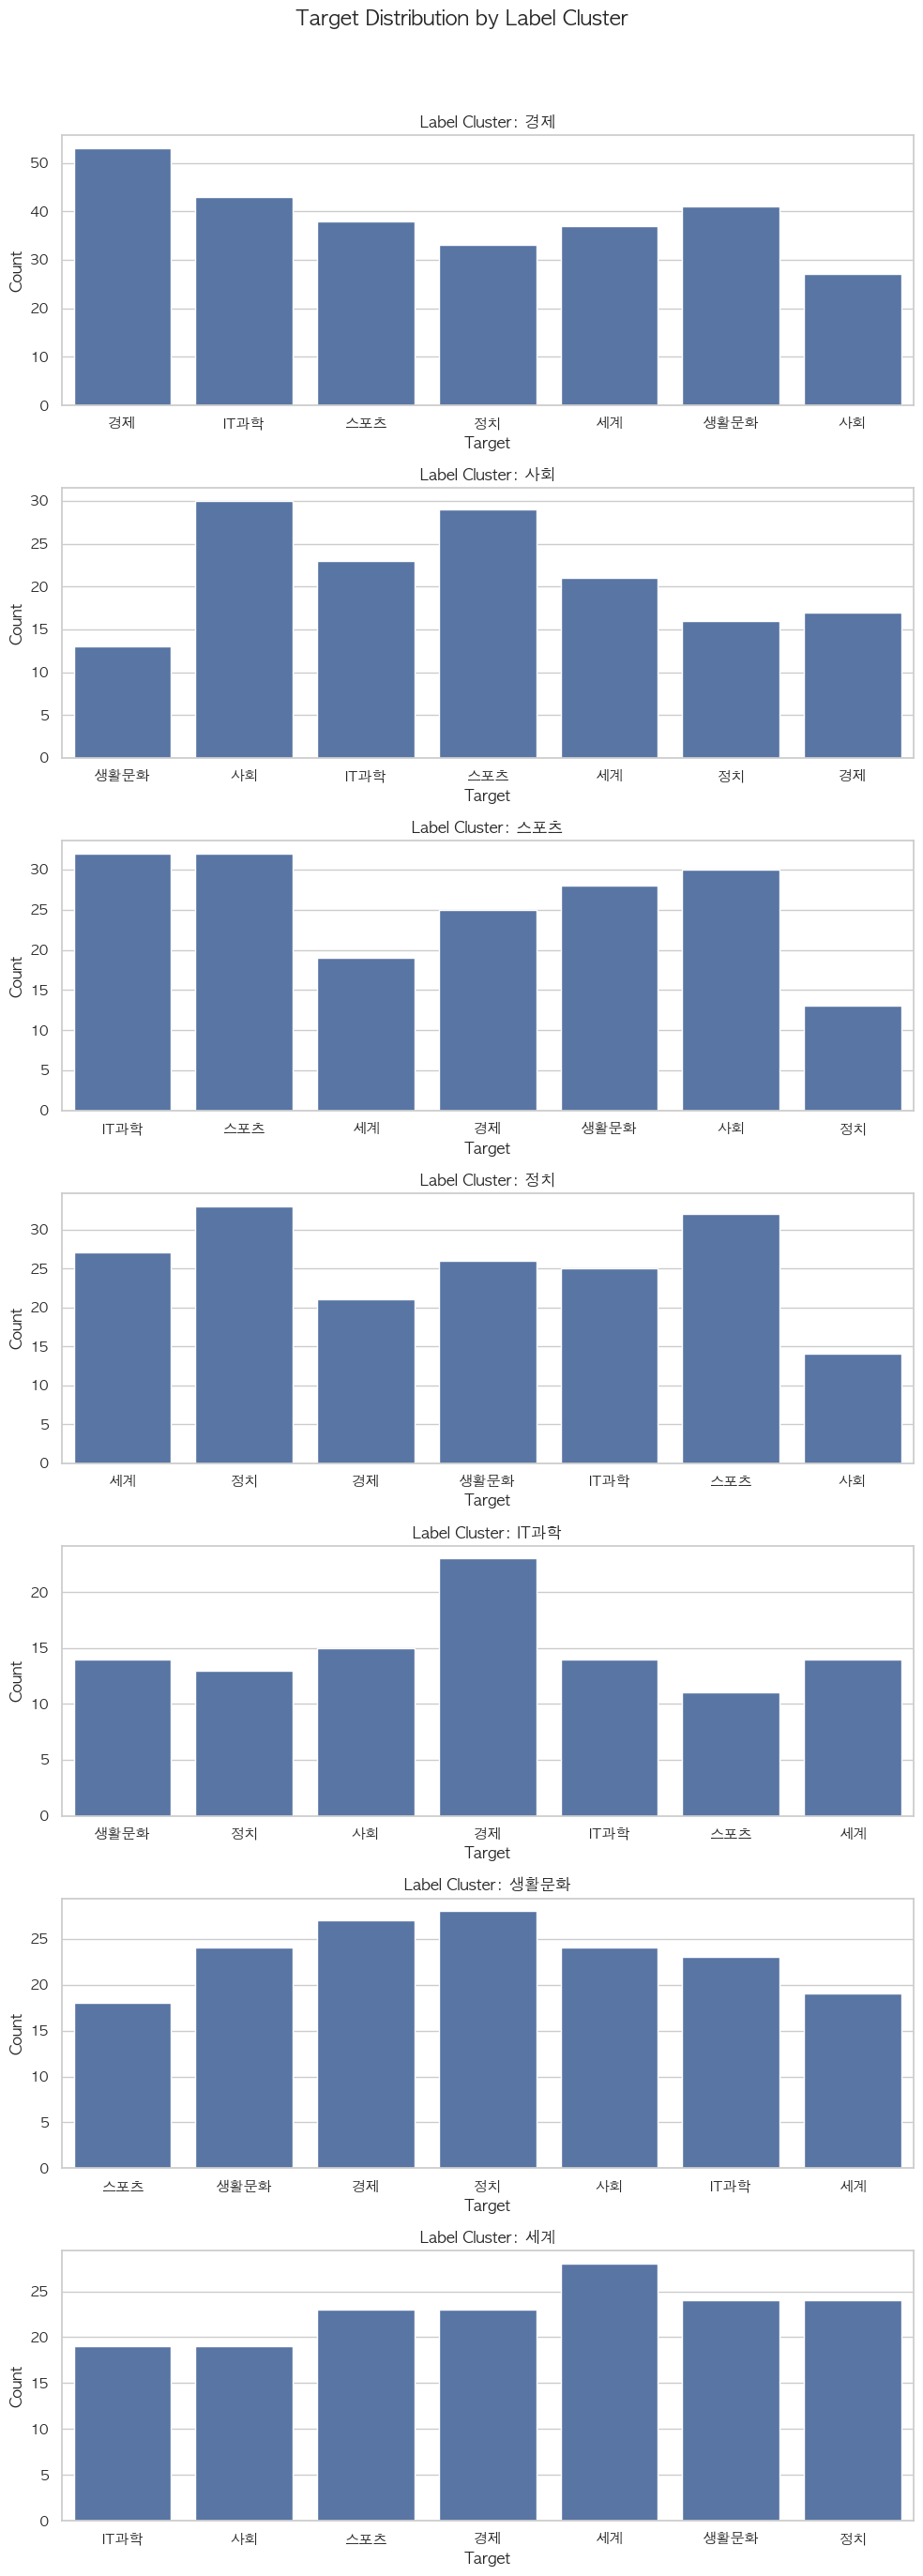

In [8]:
sns.set_theme(style="whitegrid", font='AppleGothic', rc={'axes.unicode_minus': False})

unique_clusters = clustered_df['label_cluster'].unique()

fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(10, len(unique_clusters) * 4))
fig.suptitle("Target Distribution by Label Cluster", fontsize=16)

for i, cluster in enumerate(unique_clusters):
    cluster_data = clustered_df[clustered_df['label_cluster'] == cluster]
    sns.countplot(data=cluster_data, x='target', ax=axes[i])
    axes[i].set_title(f"Label Cluster: {cluster}")
    axes[i].set_xlabel("Target")
    axes[i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()